# Install Necessary Libraries

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Configuration and Optimization (For Realistic Mode)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import(
    precision_recall_curve, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, precision_score, classification_report,
    matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler


# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "realistic"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak'] = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)


# ==============================================================================
# OPTUNA OBJECTIVE FUNCTION
# ==============================================================================
def objective(trial):
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }

    pipe = ImbPipeline([
        ("smote", smote),
        ("clf", DecisionTreeClassifier(class_weight="balanced", **params, random_state=SEED))
    ])

    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    return balanced_accuracy_score(y_val, y_val_pred)

# ==============================================================================
# RUN OPTUNA STUDY
# ==============================================================================
study = optuna.create_study(direction="maximize", study_name="DT_Realistic")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# ==============================================================================
# FINAL MODEL TRAINING
# ==============================================================================
best_params_dt = study.best_params
smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_dt['smote_level']]
best_smote_dt = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

dt_clf = DecisionTreeClassifier(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'],
    min_samples_leaf=best_params_dt['min_samples_leaf'],
    criterion=best_params_dt['criterion'],
    class_weight="balanced",
    random_state=SEED
)


final_pipe_dt = ImbPipeline([
    ("smote", best_smote_dt),
    ("clf", dt_clf)
])

final_pipe_dt.fit(X_train, y_train)

# Train on both training and validation sets combined
# since the model is finalized, we now want it to learn from all available labeled data before testing.
final_pipe_dt.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-06 22:37:06,488] A new study created in memory with name: DT_Realistic


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=realistic -> Dropped CA and PA

Features: 65  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-06 22:37:06,670] Trial 0 finished with value: 0.7731230700790286 and parameters: {'smote_level': 'small', 'max_depth': 6, 'min_samples_split': 38, 'min_samples_leaf': 12, 'criterion': 'log_loss', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7731230700790286.
[I 2025-12-06 22:37:07,317] Trial 1 finished with value: 0.7484059070846636 and parameters: {'smote_level': 'medium', 'max_depth': 12, 'min_samples_split': 50, 'min_samples_leaf': 16, 'criterion': 'entropy', 'max_features': None}. Best is trial 0 with value: 0.7731230700790286.
[I 2025-12-06 22:37:08,061] Trial 2 finished with value: 0.776293810296401 and parameters: {'smote_level': 'high', 'max_depth': 8, 'min_samples_split': 45, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_features': None}. Best is trial 2 with value: 0.776293810296401.
[I 2025-12-06 22:37:08,570] Trial 3 finished with value: 0.7792050470159279 and parameters: {'smote_level': 'small', 'max_depth': 13, 'min_samples_split': 21, 'min_samp

,steps,"[('smote', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,28


# Plot The Visualization History for the Optuna Realistic Mode

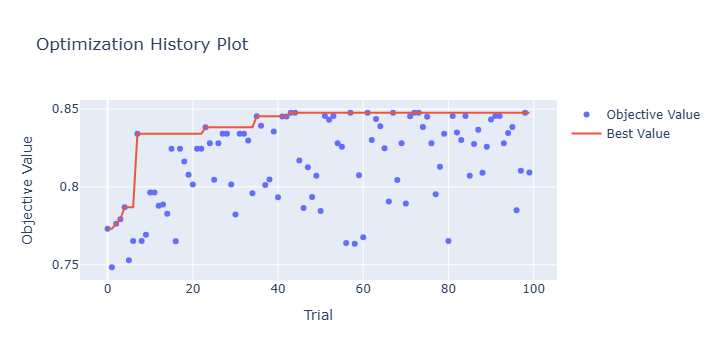

In [3]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.write_html("optimization_history_realistic.html")
fig1.show()

# Best Tuned Hyperparamter on Realistic Mode

In [4]:
print(study.best_value)
best_params

0.8476921634305054


{'smote_level': 'small',
 'max_depth': 6,
 'min_samples_split': 28,
 'min_samples_leaf': 8,
 'criterion': 'gini',
 'max_features': None}

# FINAL EVALUATION ON TEST (with both thresholds) for the Realistic Mode

In [5]:
# ==============================================================================
# FINAL EVALUATION ON TEST
# ==============================================================================
# Predict probabilities
y_test_pred_prop_dt = final_pipe_dt.predict_proba(X_test)[:, 1]

# Find thresholds
thresholds_dt = {"F1": None, "Balanced_Accuracy": None}
best_f1_dt = 0
best_bal_dt = 0

for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop_dt >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    bal_t = balanced_accuracy_score(y_test, y_pred_t)
    if f1_t > best_f1_dt:
        best_f1_dt = f1_t
        thresholds_dt["F1"] = t
    if bal_t > best_bal_dt:
        best_bal_dt = bal_t
        thresholds_dt["Balanced_Accuracy"] = t

# Predictions
y_pred_f1_dt = (y_test_pred_prop_dt >= thresholds_dt["F1"]).astype(int)
y_pred_bal_dt = (y_test_pred_prop_dt >= thresholds_dt["Balanced_Accuracy"]).astype(int)

# Metrics dicts
metrics_f1_dt = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_dt),
    "precision": precision_score(y_test, y_pred_f1_dt),
    "recall": recall_score(y_test, y_pred_f1_dt),
    "f1": f1_score(y_test, y_pred_f1_dt),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_dt),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_dt),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_dt),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_dt)
}

metrics_bal_dt = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_dt),
    "precision": precision_score(y_test, y_pred_bal_dt),
    "recall": recall_score(y_test, y_pred_bal_dt),
    "f1": f1_score(y_test, y_pred_bal_dt),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_dt),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_dt),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_dt),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_dt)
}

# Print Decision Tree results
print("\nFINAL EVALUATION ON TEST SET (Decision Tree)")
print("="*70)
print(f"\nUsing F1 Threshold ({thresholds_dt['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_dt['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_dt['precision']:.4f}")
print(f"Recall: {metrics_f1_dt['recall']:.4f}")
print(f"F1 Score: {metrics_f1_dt['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_dt['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_dt['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_dt['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_dt['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_dt))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_dt))

print(f"\nUsing Balanced Accuracy Threshold ({thresholds_dt['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_dt['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_dt['precision']:.4f}")
print(f"Recall: {metrics_bal_dt['recall']:.4f}")
print(f"F1 Score: {metrics_bal_dt['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_dt['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_dt['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_dt['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_dt['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_dt))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_dt))

best_params_dt = study.best_params
best_value_dt = study.best_value
study_dt = study

# Save Decision Tree model dict
model_dict_dt = {
    "best_params": best_params_dt,
    "best_value": best_value_dt,
    "thresholds": thresholds_dt,
    "metrics_f1": metrics_f1_dt,
    "metrics_balanced_accuracy": metrics_bal_dt,
    "study": study_dt,
    "model": final_pipe_dt
}

joblib.dump(model_dict_dt, "DT_realistic_model.pkl")


FINAL EVALUATION ON TEST SET (Decision Tree)

Using F1 Threshold (0.850)
Balanced Accuracy: 0.7230
Precision: 0.2334
Recall: 0.5023
F1 Score: 0.3187
ROC-AUC: 0.8733
Geometric Mean: 0.6885
Matthews Corr: 0.3102
Cohen Kappa: 0.2866

Confusion Matrix:
 [[6011  358]
 [ 108  109]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      6369
           1       0.23      0.50      0.32       217

    accuracy                           0.93      6586
   macro avg       0.61      0.72      0.64      6586
weighted avg       0.96      0.93      0.94      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.94      0.50      0.96      0.69      0.49      6369
          1       0.23      0.50      0.94      0.32      0.69      0.45       217

avg / total       0.96      0.93      0.52      0.94      0.69      0.49      6586


Using Balance

['DT_realistic_model.pkl']

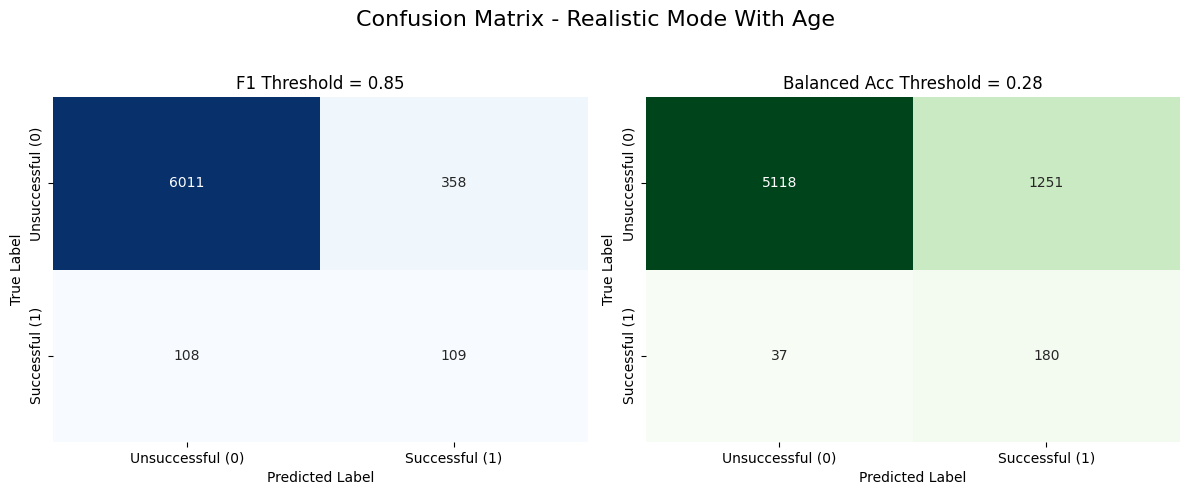

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_dt)
cm_bal = confusion_matrix(y_test, y_pred_bal_dt)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  F1 Threshold
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_dt['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Balanced Accuracy Threshold
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_dt['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Realistic Mode With Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Confusion Matrix - Realistic Mode")
plt.show()

# Data Configuration and Optimization (For Full Mode)

In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import(
    precision_recall_curve, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, precision_score, classification_report,
    matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler


# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "full"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak'] = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)


# ==============================================================================
# OPTUNA OBJECTIVE FUNCTION
# ==============================================================================
def objective(trial):
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }

    pipe = ImbPipeline([
        ("smote", smote),
        ("clf", DecisionTreeClassifier(class_weight="balanced", **params, random_state=SEED))
    ])

    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    return balanced_accuracy_score(y_val, y_val_pred)

# ==============================================================================
# RUN OPTUNA STUDY
# ==============================================================================
study = optuna.create_study(direction="maximize", study_name="DT_Full")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# ==============================================================================
# FINAL MODEL TRAINING
# ==============================================================================
best_params_dt = study.best_params
smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_dt['smote_level']]
best_smote_dt = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

dt_clf = DecisionTreeClassifier(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'],
    min_samples_leaf=best_params_dt['min_samples_leaf'],
    criterion=best_params_dt['criterion'],
    class_weight="balanced",
    random_state=SEED
)


final_pipe_dt = ImbPipeline([
    ("smote", best_smote_dt),
    ("clf", dt_clf)
])

final_pipe_dt.fit(X_train, y_train)

# Train on both training and validation sets combined
# since the model is finalized, we now want it to learn from all available labeled data before testing.
final_pipe_dt.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-06 22:38:52,475] A new study created in memory with name: DT_Full


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 69  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-06 22:38:54,191] Trial 0 finished with value: 0.7843057082046719 and parameters: {'smote_level': 'small', 'max_depth': 15, 'min_samples_split': 37, 'min_samples_leaf': 8, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.7843057082046719.
[I 2025-12-06 22:38:54,680] Trial 1 finished with value: 0.8257390397934439 and parameters: {'smote_level': 'small', 'max_depth': 9, 'min_samples_split': 28, 'min_samples_leaf': 7, 'criterion': 'entropy', 'max_features': None}. Best is trial 1 with value: 0.8257390397934439.
[I 2025-12-06 22:38:55,235] Trial 2 finished with value: 0.863934029413304 and parameters: {'smote_level': 'high', 'max_depth': 4, 'min_samples_split': 25, 'min_samples_leaf': 16, 'criterion': 'entropy', 'max_features': None}. Best is trial 2 with value: 0.863934029413304.
[I 2025-12-06 22:38:55,745] Trial 3 finished with value: 0.8248395003576351 and parameters: {'smote_level': 'small', 'max_depth': 11, 'min_samples_split': 47, 'min_samples_le

,steps,"[('smote', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,criterion,'log_loss'
,splitter,'best'
,max_depth,5
,min_samples_split,34


# Plot The Visualization History for the Optuna Full Mode

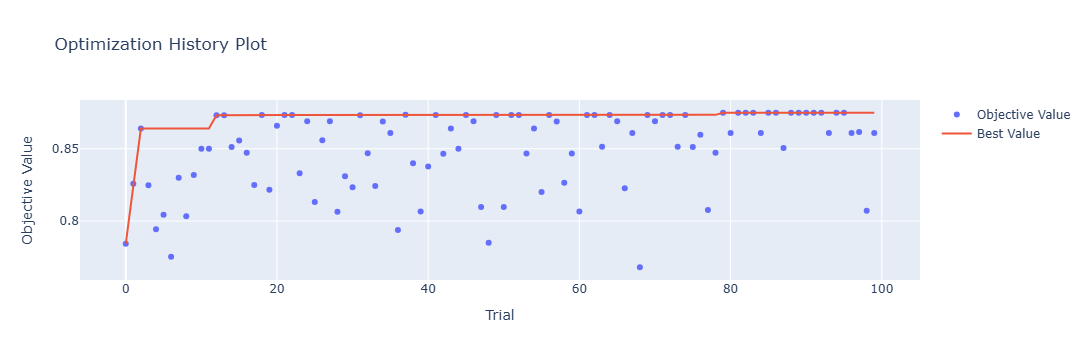

In [8]:
fig2 = optuna.visualization.plot_optimization_history(study)
fig2.write_html("optimization_history_full.html")
fig2.show()

# Best Tuned Hyperparamter on Full Mode

In [9]:
print(study.best_value)
best_params

0.8748484412344516


{'smote_level': 'small',
 'max_depth': 5,
 'min_samples_split': 34,
 'min_samples_leaf': 7,
 'criterion': 'log_loss',
 'max_features': None}

# FINAL EVALUATION ON TEST (with both thresholds) for the Full Mode

In [10]:
# ==============================================================================
# FINAL EVALUATION ON TEST
# ==============================================================================
# Predict probabilities
y_test_pred_prop_dt = final_pipe_dt.predict_proba(X_test)[:, 1]

# Find thresholds
thresholds_dt = {"F1": None, "Balanced_Accuracy": None}
best_f1_dt = 0
best_bal_dt = 0

for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop_dt >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    bal_t = balanced_accuracy_score(y_test, y_pred_t)
    if f1_t > best_f1_dt:
        best_f1_dt = f1_t
        thresholds_dt["F1"] = t
    if bal_t > best_bal_dt:
        best_bal_dt = bal_t
        thresholds_dt["Balanced_Accuracy"] = t

# Predictions
y_pred_f1_dt = (y_test_pred_prop_dt >= thresholds_dt["F1"]).astype(int)
y_pred_bal_dt = (y_test_pred_prop_dt >= thresholds_dt["Balanced_Accuracy"]).astype(int)

# Metrics dicts
metrics_f1_dt = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_dt),
    "precision": precision_score(y_test, y_pred_f1_dt),
    "recall": recall_score(y_test, y_pred_f1_dt),
    "f1": f1_score(y_test, y_pred_f1_dt),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_dt),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_dt),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_dt),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_dt)
}

metrics_bal_dt = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_dt),
    "precision": precision_score(y_test, y_pred_bal_dt),
    "recall": recall_score(y_test, y_pred_bal_dt),
    "f1": f1_score(y_test, y_pred_bal_dt),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_dt),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_dt),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_dt),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_dt)
}

# Print Decision Tree results
print("\nFINAL EVALUATION ON TEST SET (Decision Tree)")
print("="*70)
print(f"\nUsing F1 Threshold ({thresholds_dt['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_dt['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_dt['precision']:.4f}")
print(f"Recall: {metrics_f1_dt['recall']:.4f}")
print(f"F1 Score: {metrics_f1_dt['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_dt['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_dt['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_dt['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_dt['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_dt))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_dt))

print(f"\nUsing Balanced Accuracy Threshold ({thresholds_dt['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_dt['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_dt['precision']:.4f}")
print(f"Recall: {metrics_bal_dt['recall']:.4f}")
print(f"F1 Score: {metrics_bal_dt['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_dt['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_dt['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_dt['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_dt['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_dt))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_dt))

best_params_dt = study.best_params
best_value_dt = study.best_value
study_dt = study

# Save Decision Tree model dict
model_dict_dt = {
    "best_params": best_params_dt,
    "best_value": best_value_dt,
    "thresholds": thresholds_dt,
    "metrics_f1": metrics_f1_dt,
    "metrics_balanced_accuracy": metrics_bal_dt,
    "study": study_dt,
    "model": final_pipe_dt
}

joblib.dump(model_dict_dt, "DT_full_model.pkl")


FINAL EVALUATION ON TEST SET (Decision Tree)

Using F1 Threshold (0.840)
Balanced Accuracy: 0.7300
Precision: 0.3681
Recall: 0.4885
F1 Score: 0.4198
ROC-AUC: 0.9381
Geometric Mean: 0.6889
Matthews Corr: 0.4015
Cohen Kappa: 0.3971

Confusion Matrix:
 [[6187  182]
 [ 111  106]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      6369
           1       0.37      0.49      0.42       217

    accuracy                           0.96      6586
   macro avg       0.68      0.73      0.70      6586
weighted avg       0.96      0.96      0.96      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.97      0.49      0.98      0.69      0.50      6369
          1       0.37      0.49      0.97      0.42      0.69      0.45       217

avg / total       0.96      0.96      0.50      0.96      0.69      0.50      6586


Using Balance

['DT_full_model.pkl']

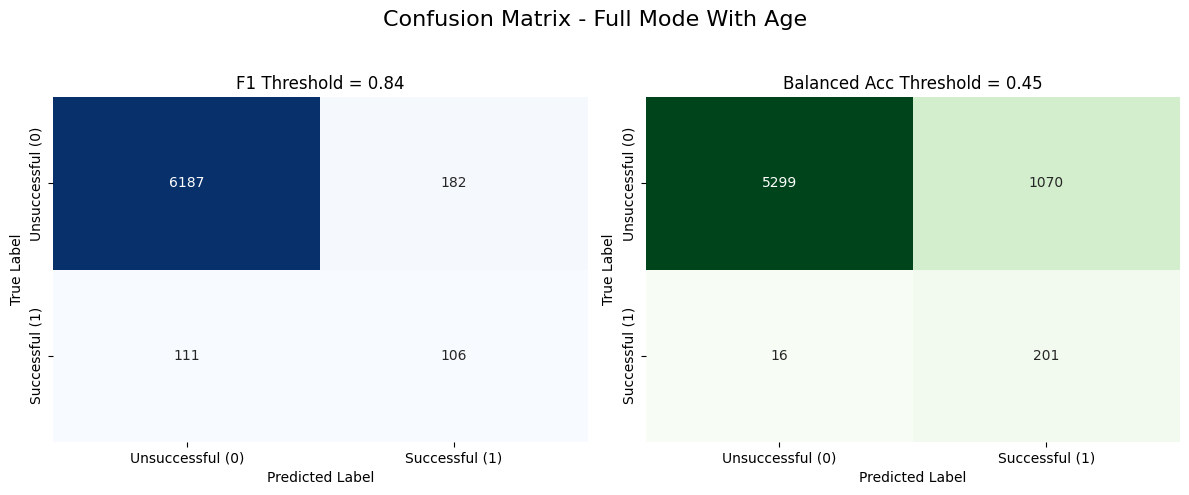

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_dt)
cm_bal = confusion_matrix(y_test, y_pred_bal_dt)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  F1 Threshold
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_dt['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Balanced Accuracy Threshold
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_dt['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Full Mode With Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Confusion Matrix - Full Mode")
plt.show()

# visualize the comparison of the models based on different metrics.

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import joblib

dt_realistic_model = joblib.load("DT_realistic_model.pkl")

dt_full_model = joblib.load("DT_full_model.pkl")

print("Realistic Model Metrics (F1 Optimal Threshold):")
print(dt_realistic_model['metrics_f1'])

print("\nFull Model Metrics (F1 Optimal Threshold):")
print(dt_full_model['metrics_f1'])

print("\nRealistic Model Metrics (Balanced Accuracy Optimal Threshold):")
print(dt_realistic_model['metrics_balanced_accuracy'])

print("\nFull Model Metrics (Balanced Accuracy Optimal Threshold):")
print(dt_full_model['metrics_balanced_accuracy'])

Realistic Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.7230471907055561, 'precision': 0.2334047109207709, 'recall': 0.5023041474654378, 'f1': 0.31871345029239767, 'roc_auc': 0.8733218144048831, 'geometric_mean': np.float64(0.6885272317405378), 'matthews_corrcoef': 0.3102369897688499, 'cohen_kappa': 0.2866174230256249}

Full Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.7299516740432669, 'precision': 0.3680555555555556, 'recall': 0.48847926267281105, 'f1': 0.4198019801980198, 'roc_auc': 0.9381183193651856, 'geometric_mean': np.float64(0.6888544991400616), 'matthews_corrcoef': 0.40145279931167455, 'cohen_kappa': 0.397146086553379}

Realistic Model Metrics (Balanced Accuracy Optimal Threshold):
{'balanced_accuracy': 0.8165364637034368, 'precision': 0.12578616352201258, 'recall': 0.8294930875576036, 'f1': 0.21844660194174756, 'roc_auc': 0.8733218144048831, 'geometric_mean': np.float64(0.8164336607806023), 'matthews_corrcoef': 0.274021779000852, 'cohen_kappa

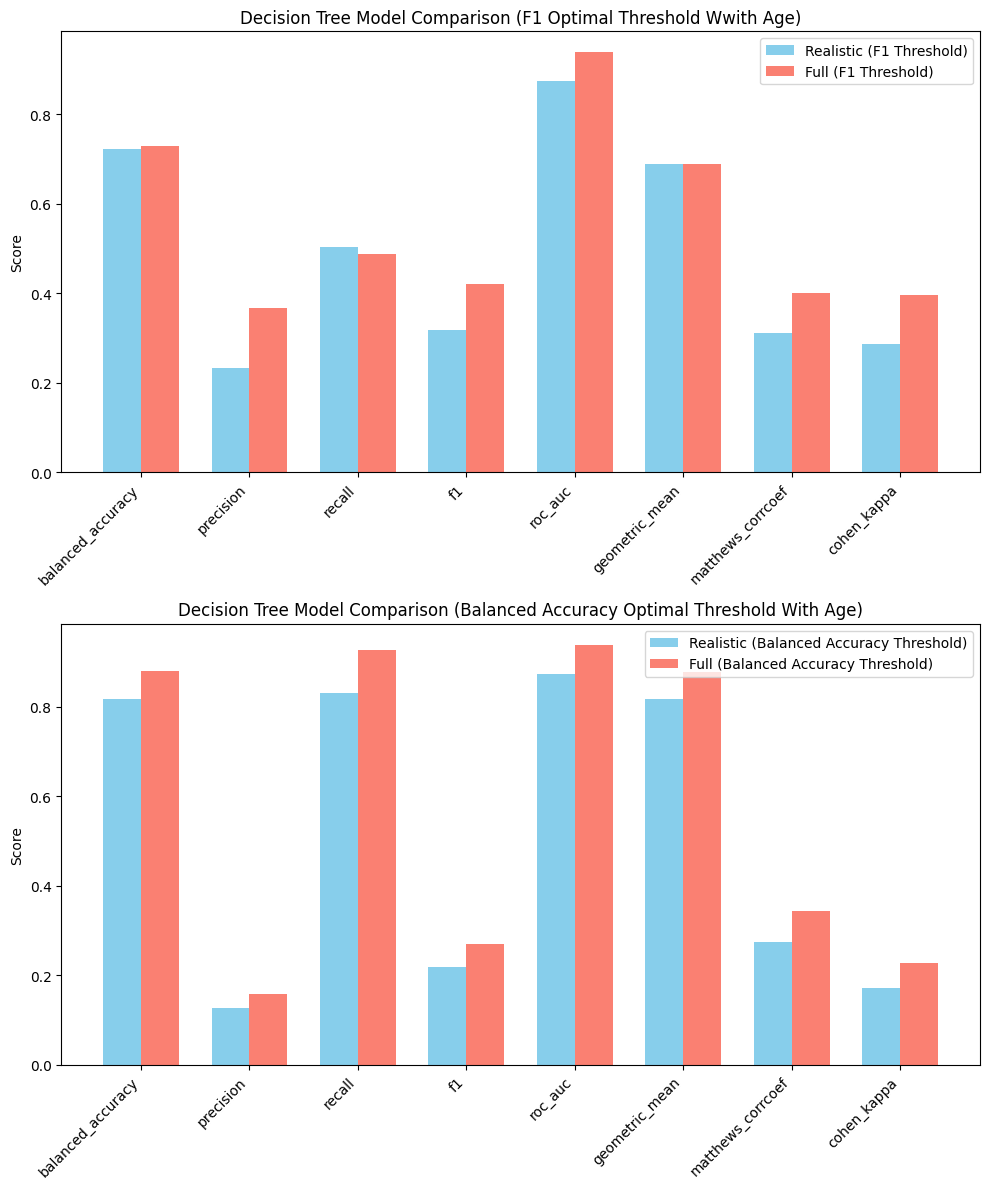

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

metrics_f1_realistic = dt_realistic_model['metrics_f1']
metrics_f1_full = dt_full_model['metrics_f1']
metrics_bal_realistic = dt_realistic_model['metrics_balanced_accuracy']
metrics_bal_full = dt_full_model['metrics_balanced_accuracy']

df_f1 = pd.DataFrame({
    "Metric": metrics_f1_realistic.keys(),
    "Realistic (F1 Threshold)": metrics_f1_realistic.values(),
    "Full (F1 Threshold)": metrics_f1_full.values()
})

df_bal = pd.DataFrame({
    "Metric": metrics_bal_realistic.keys(),
    "Realistic (Balanced Accuracy Threshold)": metrics_bal_realistic.values(),
    "Full (Balanced Accuracy Threshold)": metrics_bal_full.values()
})

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

bar_width = 0.35
x_f1 = np.arange(len(df_f1["Metric"]))

rects1_f1 = axes[0].bar(x_f1 - bar_width/2, df_f1["Realistic (F1 Threshold)"], bar_width, label='Realistic (F1 Threshold)', color='skyblue')
rects2_f1 = axes[0].bar(x_f1 + bar_width/2, df_f1["Full (F1 Threshold)"], bar_width, label='Full (F1 Threshold)', color='salmon')

axes[0].set_ylabel("Score")
axes[0].set_title("Decision Tree Model Comparison (F1 Optimal Threshold Wwith Age)")
axes[0].set_xticks(x_f1)
axes[0].set_xticklabels(df_f1["Metric"], rotation=45, ha='right')
axes[0].legend()

bar_width = 0.35
x_bal = np.arange(len(df_bal["Metric"]))

rects1_bal = axes[1].bar(x_bal - bar_width/2, df_bal["Realistic (Balanced Accuracy Threshold)"], bar_width, label='Realistic (Balanced Accuracy Threshold)', color='skyblue')
rects2_bal = axes[1].bar(x_bal + bar_width/2, df_bal["Full (Balanced Accuracy Threshold)"], bar_width, label='Full (Balanced Accuracy Threshold)', color='salmon')

axes[1].set_ylabel("Score")
axes[1].set_title("Decision Tree Model Comparison (Balanced Accuracy Optimal Threshold With Age)")
axes[1].set_xticks(x_bal)
axes[1].set_xticklabels(df_bal["Metric"], rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.savefig("dt_model_comparison_2x1_grid.png")
plt.show()

Reading file...
Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 69  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


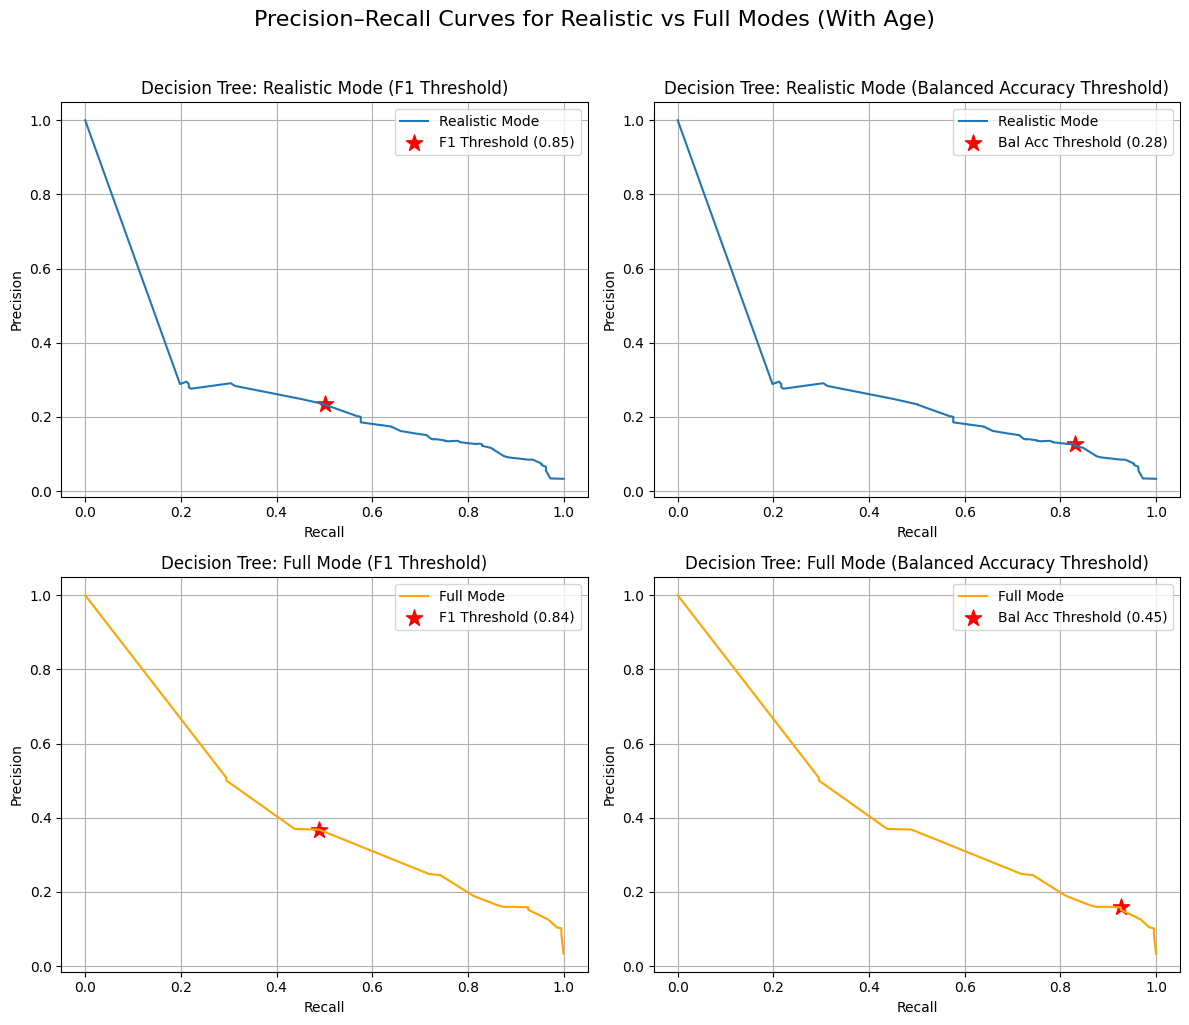

In [4]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# ==============================================================================
# CONFIGURATION
# ==============================================================================
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"

# ==============================================================================
# Load Models
# ==============================================================================
dt_realistic_model = joblib.load("DT_realistic_model.pkl")
dt_full_model = joblib.load("DT_full_model.pkl")


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")

drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

MODE = "full"
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak'] = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

X_test_realistic = X_test.drop(columns=[c for c in ["CA", "PA", "Growth_Ratio", "Growth_Room"] if c in X_test.columns], errors='ignore')
X_test_full = X_test.copy()


# ==============================================================================
# Plotting Precision-Recall Curves (2x2 Grid)
# ==============================================================================

y_test_pred_prop_realistic = dt_realistic_model['model'].predict_proba(X_test_realistic)[:, 1]
y_test_pred_prop_full = dt_full_model['model'].predict_proba(X_test_full)[:, 1]

precision_realistic, recall_realistic, thresholds_realistic = precision_recall_curve(y_test, y_test_pred_prop_realistic)

precision_full, recall_full, thresholds_full = precision_recall_curve(y_test, y_test_pred_prop_full)

f1_threshold_realistic = dt_realistic_model['thresholds']['F1']
bal_acc_threshold_realistic = dt_realistic_model['thresholds']['Balanced_Accuracy']
f1_threshold_full = dt_full_model['thresholds']['F1']
bal_acc_threshold_full = dt_full_model['thresholds']['Balanced_Accuracy']

f1_idx_realistic = np.argmax(thresholds_realistic >= f1_threshold_realistic) if np.any(thresholds_realistic >= f1_threshold_realistic) else len(thresholds_realistic) - 1
f1_precision_realistic = precision_realistic[f1_idx_realistic]
f1_recall_realistic = recall_realistic[f1_idx_realistic]

bal_acc_idx_realistic = np.argmax(thresholds_realistic >= bal_acc_threshold_realistic) if np.any(thresholds_realistic >= bal_acc_threshold_realistic) else len(thresholds_realistic) - 1
bal_acc_precision_realistic = precision_realistic[bal_acc_idx_realistic]
bal_acc_recall_realistic = recall_realistic[bal_acc_idx_realistic]

f1_idx_full = np.argmax(thresholds_full >= f1_threshold_full) if np.any(thresholds_full >= f1_threshold_full) else len(thresholds_full) - 1
f1_precision_full = precision_full[f1_idx_full]
f1_recall_full = recall_full[f1_idx_full]

bal_acc_idx_full = np.argmax(thresholds_full >= bal_acc_threshold_full) if np.any(thresholds_full >= bal_acc_threshold_full) else len(thresholds_full) - 1
bal_acc_precision_full = precision_full[bal_acc_idx_full]
bal_acc_recall_full = recall_full[bal_acc_idx_full]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')
axes[0, 0].scatter(f1_recall_realistic, f1_precision_realistic, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_realistic:.2f})')
axes[0, 0].set_xlabel("Recall")
axes[0, 0].set_ylabel("Precision")
axes[0, 0].set_title("Decision Tree: Realistic Mode (F1 Threshold)")
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')
axes[0, 1].scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Decision Tree: Realistic Mode (Balanced Accuracy Threshold)")
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')
axes[1, 0].scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_full:.2f})')
axes[1, 0].set_xlabel("Recall")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].set_title("Decision Tree: Full Mode (F1 Threshold)")
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')
axes[1, 1].scatter(bal_acc_recall_full, bal_acc_precision_full, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_full:.2f})')
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].set_title("Decision Tree: Full Mode (Balanced Accuracy Threshold)")
axes[1, 1].legend()
axes[1, 1].grid(True)

fig.suptitle(
    "Precision–Recall Curves for Realistic vs Full Modes (With Age)",
    fontsize=16,
    y=1.02
)
plt.tight_layout()
plt.savefig("dt_precision_recall_4grid.png")
plt.show()

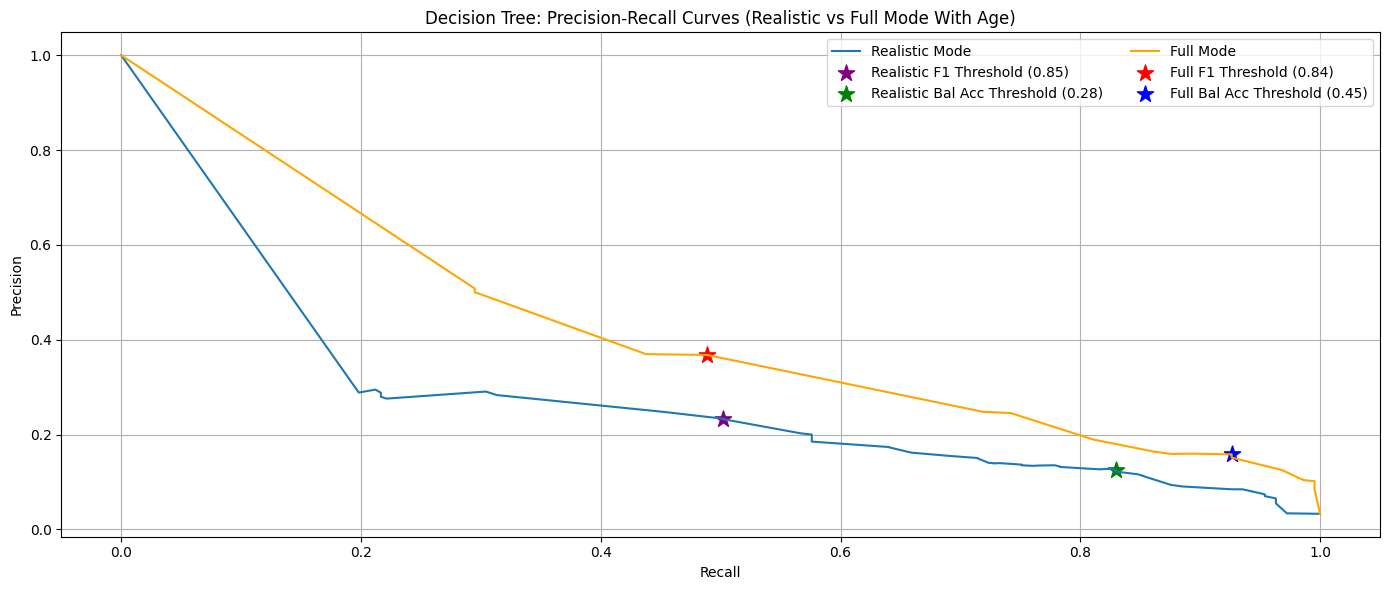

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Realistic Mode 
plt.plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')
plt.scatter(f1_recall_realistic, f1_precision_realistic, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({f1_threshold_realistic:.2f})')
plt.scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='green', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')

# Full Mode
plt.plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')
plt.scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({f1_threshold_full:.2f})')
plt.scatter(bal_acc_recall_full, bal_acc_precision_full, color='blue', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({bal_acc_threshold_full:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Decision Tree: Precision-Recall Curves (Realistic vs Full Mode With Age)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("dt_precision_recall_combined.png")
plt.show()

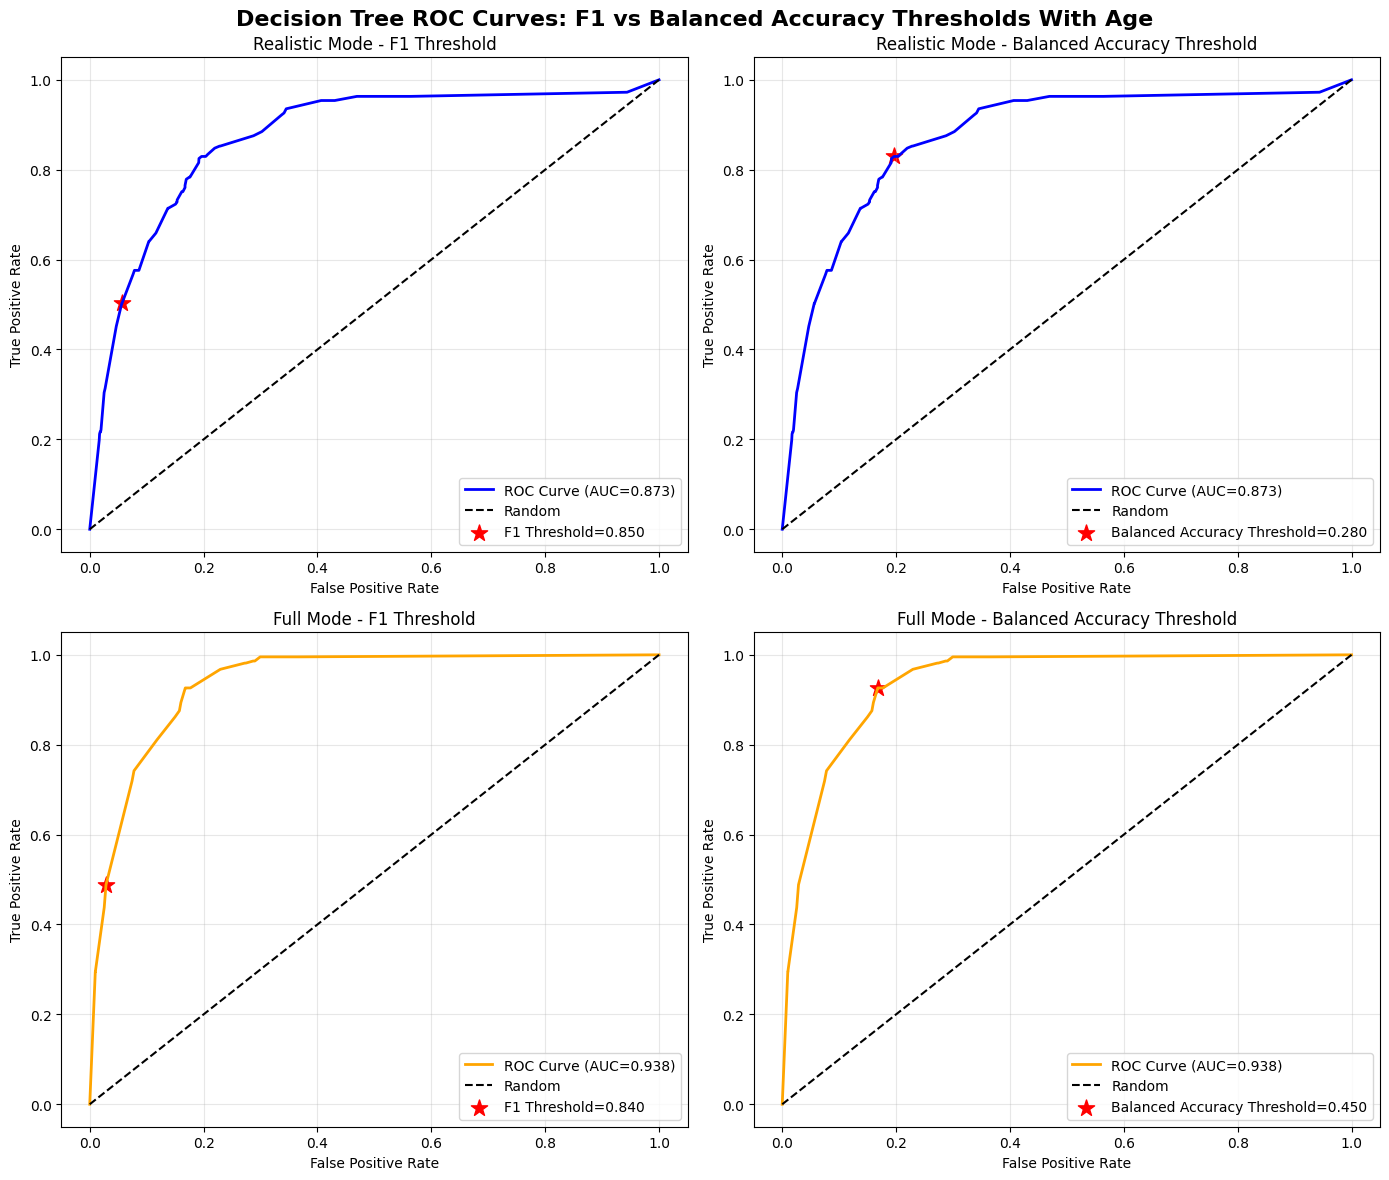

In [6]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Decision Tree ROC Curves: F1 vs Balanced Accuracy Thresholds With Age', fontsize=16, fontweight='bold')

# -----------------------------
# Realistic Mode
# -----------------------------
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
roc_auc_real = auc(fpr_real, tpr_real)

fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, dt_realistic_model['thresholds']['F1'])
axes[0, 0].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 0].scatter(fpr_f1_real, tpr_f1_real, color='red', s=150, marker='*',
                   label=f'F1 Threshold={dt_realistic_model["thresholds"]["F1"]:.3f}')
axes[0, 0].set_title('Realistic Mode - F1 Threshold')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(loc='best')

fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, dt_realistic_model['thresholds']['Balanced_Accuracy'])
axes[0, 1].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 1].scatter(fpr_bal_real, tpr_bal_real, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={dt_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0, 1].set_title('Realistic Mode - Balanced Accuracy Threshold')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(loc='best')

# -----------------------------
# Full Mode
# -----------------------------
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)
roc_auc_full = auc(fpr_full, tpr_full)

fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, dt_full_model['thresholds']['F1'])
axes[1, 0].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 0].scatter(fpr_f1_full, tpr_f1_full, color='red', s=150, marker='*',
                   label=f'F1 Threshold={dt_full_model["thresholds"]["F1"]:.3f}')
axes[1, 0].set_title('Full Mode - F1 Threshold')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(loc='best')

fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, dt_full_model['thresholds']['Balanced_Accuracy'])
axes[1, 1].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 1].scatter(fpr_bal_full, tpr_bal_full, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={dt_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1, 1].set_title('Full Mode - Balanced Accuracy Threshold')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.savefig("dt_roc_2x2_grid.png", dpi=300, bbox_inches='tight')
plt.show()

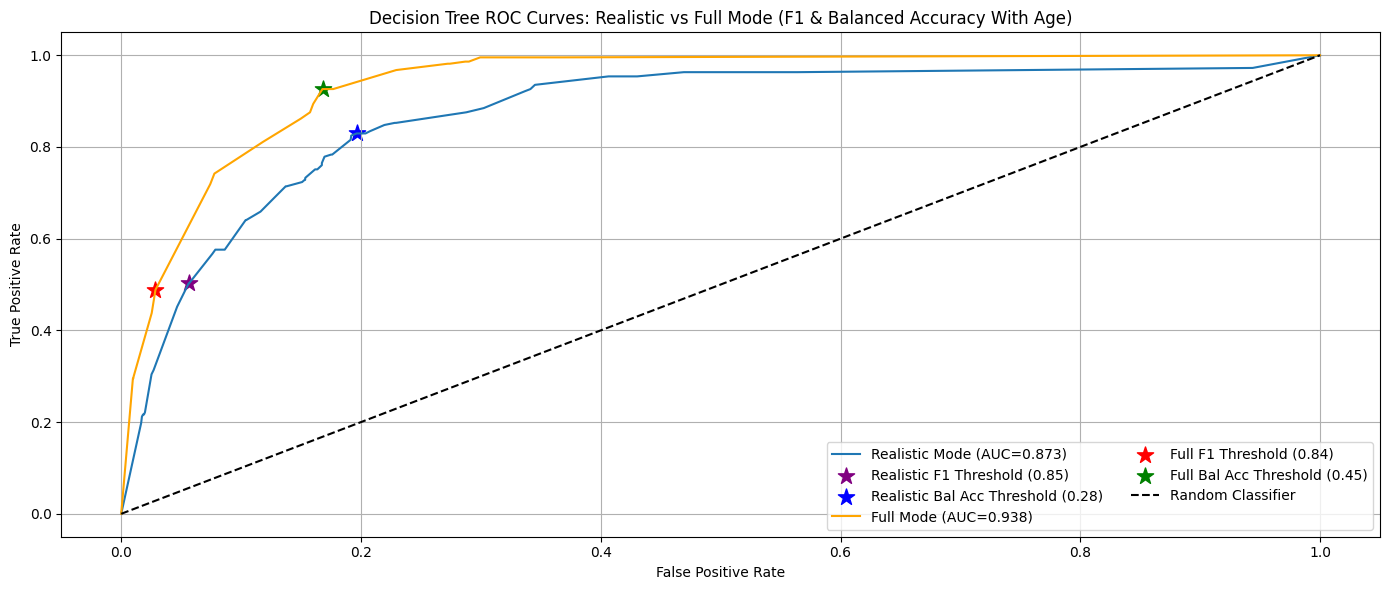

In [7]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)

roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_full = auc(fpr_full, tpr_full)

# Compute points for thresholds
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, dt_realistic_model['thresholds']['F1'])
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, dt_realistic_model['thresholds']['Balanced_Accuracy'])

fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, dt_full_model['thresholds']['F1'])
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, dt_full_model['thresholds']['Balanced_Accuracy'])

# Plot combined ROC
plt.figure(figsize=(14, 6))

# Realistic Mode 
plt.plot(fpr_real, tpr_real, label=f'Realistic Mode (AUC={roc_auc_real:.3f})', linestyle='-')
plt.scatter(fpr_f1_real, tpr_f1_real, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({dt_realistic_model["thresholds"]["F1"]:.2f})')
plt.scatter(fpr_bal_real, tpr_bal_real, color='blue', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({dt_realistic_model["thresholds"]["Balanced_Accuracy"]:.2f})')

# Full Mode
plt.plot(fpr_full, tpr_full, label=f'Full Mode (AUC={roc_auc_full:.3f})', color='orange', linestyle='-')
plt.scatter(fpr_f1_full, tpr_f1_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({dt_full_model["thresholds"]["F1"]:.2f})')
plt.scatter(fpr_bal_full, tpr_bal_full, color='green', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({dt_full_model["thresholds"]["Balanced_Accuracy"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC Curves: Realistic vs Full Mode (F1 & Balanced Accuracy With Age)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("dt_roc_combined.png", dpi=300)
plt.show()

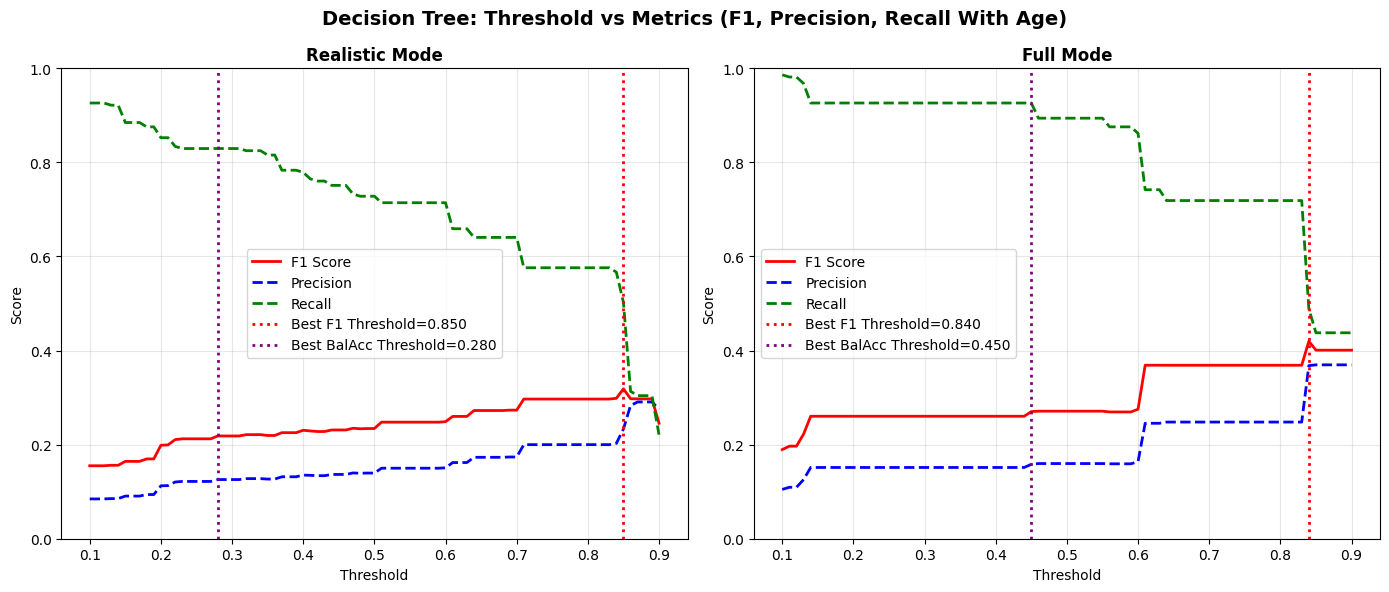

In [8]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Define threshold range
threshold_range = np.arange(0.1, 0.91, 0.01)

def compute_metrics(y_true, y_pred_prop, threshold_range):
    f1_scores, bal_acc_scores, precision_scores, recall_scores = [], [], [], []
    for t in threshold_range:
        y_pred_t = (y_pred_prop >= t).astype(int)
        f1_scores.append(f1_score(y_true, y_pred_t))
        bal_acc_scores.append(balanced_accuracy_score(y_true, y_pred_t))
        precision_scores.append(precision_score(y_true, y_pred_t))
        recall_scores.append(recall_score(y_true, y_pred_t))
    return f1_scores, bal_acc_scores, precision_scores, recall_scores

# Realistic Mode 
f1_scores_real, bal_acc_scores_real, precision_scores_real, recall_scores_real = compute_metrics(
    y_test, y_test_pred_prop_realistic, threshold_range
)

# Full Mode
f1_scores_full, bal_acc_scores_full, precision_scores_full, recall_scores_full = compute_metrics(
    y_test, y_test_pred_prop_full, threshold_range
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Decision Tree: Threshold vs Metrics (F1, Precision, Recall With Age)', fontsize=14, fontweight='bold')

# Realistic Mode 
axes[0].plot(threshold_range, f1_scores_real, 'r-', linewidth=2, label='F1 Score')
axes[0].plot(threshold_range, precision_scores_real, 'b--', linewidth=2, label='Precision')
axes[0].plot(threshold_range, recall_scores_real, 'g--', linewidth=2, label='Recall')
axes[0].axvline(dt_realistic_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,
                label=f'Best F1 Threshold={dt_realistic_model["thresholds"]["F1"]:.3f}')
axes[0].axvline(dt_realistic_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,
                label=f'Best BalAcc Threshold={dt_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0].set_title('Realistic Mode', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([0, 1])

# Full Mode
axes[1].plot(threshold_range, f1_scores_full, 'r-', linewidth=2, label='F1 Score')
axes[1].plot(threshold_range, precision_scores_full, 'b--', linewidth=2, label='Precision')
axes[1].plot(threshold_range, recall_scores_full, 'g--', linewidth=2, label='Recall')
axes[1].axvline(dt_full_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,
                label=f'Best F1 Threshold={dt_full_model["thresholds"]["F1"]:.3f}')
axes[1].axvline(dt_full_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,
                label=f'Best BalAcc Threshold={dt_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1].set_title('Full Mode', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("dt_threshold_vs_metrics_pair_combined.png", dpi=300, bbox_inches='tight')
plt.show()


[CHECK] Realistic mode: model vs reconstructed
65 65

[CHECK] Full mode: model vs reconstructed
69 69


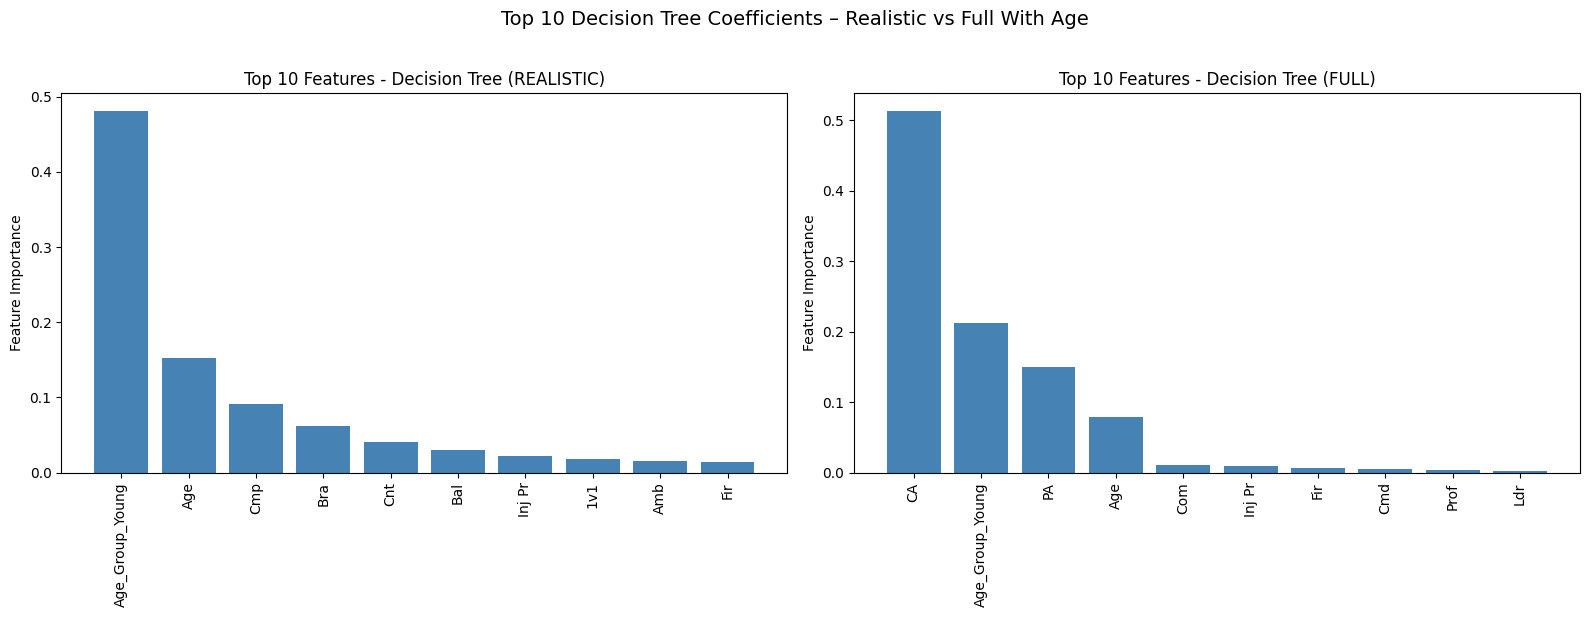


===== TOP 10 FEATURES — REALISTIC MODE =====
Age_Group_Young: 0.4805
Age: 0.1528
Cmp: 0.0911
Bra: 0.0618
Cnt: 0.0403
Bal: 0.0295
Inj Pr: 0.0219
1v1: 0.0187
Amb: 0.0161
Fir: 0.0146

===== TOP 10 FEATURES — FULL MODE =====
CA: 0.5123
Age_Group_Young: 0.2117
PA: 0.1499
Age: 0.0796
Com: 0.0106
Inj Pr: 0.0101
Fir: 0.0066
Cmd: 0.0057
Prof: 0.0034
Ldr: 0.0029


In [10]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==============================================================================
# CONFIGURATION
# ==============================================================================
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"

# ==============================================================================
# LOAD MODELS
# ==============================================================================
model_dt_realistic = joblib.load("DT_realistic_model.pkl")["model"]
model_dt_full = joblib.load("DT_full_model.pkl")["model"]

importances_realistic = model_dt_realistic.named_steps["clf"].feature_importances_
importances_full = model_dt_full.named_steps["clf"].feature_importances_

# ==============================================================================
# REBUILD FEATURE COLUMNS EXACTLY LIKE TRAINING
# ==============================================================================

# Columns dropped during training
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]

# ------------------------------------------------------------------------------
# REALISTIC MODE FEATURE RECONSTRUCTION
# ------------------------------------------------------------------------------
df_temp = pd.read_excel(FILE_PATH)
df_temp_realistic = df_temp.drop(columns=[c for c in drop_cols if c in df_temp.columns], errors='ignore')

# Remove hidden attributes
df_temp_realistic = df_temp_realistic.drop(columns=["CA", "PA"], errors='ignore')

# Add age groups (same logic as training)
if "Age" in df_temp_realistic.columns:
    df_temp_realistic["Age_Group_Young"] = (df_temp_realistic["Age"] <= 20).astype(int)
    df_temp_realistic["Age_Group_Peak"]  = ((df_temp_realistic["Age"] > 20) & (df_temp_realistic["Age"] <= 23)).astype(int)

# Final realistic mode features
X_realistic_cols = df_temp_realistic.drop(columns=["success_label"]).columns


# ------------------------------------------------------------------------------
# FULL MODE FEATURE RECONSTRUCTION
# ------------------------------------------------------------------------------
df_temp_full = df_temp.drop(columns=[c for c in drop_cols if c in df_temp.columns], errors='ignore')

# Keep CA/PA and add derived growth attributes
if all(col in df_temp_full.columns for col in ["PA", "CA"]):
    df_temp_full["Growth_Ratio"] = df_temp_full["PA"] / df_temp_full["CA"].replace(0, 1)
    df_temp_full["Growth_Room"]  = df_temp_full["PA"] - df_temp_full["CA"]

# Add age groups
if "Age" in df_temp_full.columns:
    df_temp_full["Age_Group_Young"] = (df_temp_full["Age"] <= 20).astype(int)
    df_temp_full["Age_Group_Peak"]  = ((df_temp_full["Age"] > 20) & (df_temp_full["Age"] <= 23)).astype(int)

# Final full mode features
X_full_cols = df_temp_full.drop(columns=["success_label"]).columns


# ==============================================================================
# SAFETY CHECK — MUST MATCH FEATURE IMPORTANCE LENGTHS
# ==============================================================================
print("\n[CHECK] Realistic mode: model vs reconstructed")
print(len(importances_realistic), len(X_realistic_cols))

print("\n[CHECK] Full mode: model vs reconstructed")
print(len(importances_full), len(X_full_cols))

# If mismatched, STOP
if len(importances_realistic) != len(X_realistic_cols):
    raise ValueError("Realistic feature count mismatch — check preprocessing.")

if len(importances_full) != len(X_full_cols):
    raise ValueError("Full mode feature count mismatch — check preprocessing.")


# ==============================================================================
# FIND TOP N FEATURES
# ==============================================================================
top_n = 10

indices_realistic = np.argsort(importances_realistic)[::-1][:top_n]
indices_full = np.argsort(importances_full)[::-1][:top_n]

top_features_realistic = [X_realistic_cols[i] for i in indices_realistic]
top_importances_realistic = importances_realistic[indices_realistic]

top_features_full = [X_full_cols[i] for i in indices_full]
top_importances_full = importances_full[indices_full]


# ==============================================================================
# PLOTS
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Realistic Mode Plot
axes[0].bar(range(top_n), top_importances_realistic, color='steelblue')
axes[0].set_xticks(range(top_n))
axes[0].set_xticklabels(top_features_realistic, rotation=90)
axes[0].set_title("Top 10 Features - Decision Tree (REALISTIC)")
axes[0].set_ylabel("Feature Importance")

# Full Mode Plot
axes[1].bar(range(top_n), top_importances_full, color='steelblue')
axes[1].set_xticks(range(top_n))
axes[1].set_xticklabels(top_features_full, rotation=90)
axes[1].set_title("Top 10 Features - Decision Tree (FULL)")
axes[1].set_ylabel("Feature Importance")

fig.suptitle("Top 10 Decision Tree Coefficients – Realistic vs Full With Age", fontsize=14, y=1.02)


plt.tight_layout()
plt.savefig("top_10_features_dt_comparison.png", dpi=300)
plt.show()


# ==============================================================================
# PRINT RESULTS
# ==============================================================================
print("\n===== TOP 10 FEATURES — REALISTIC MODE =====")
for f, imp in zip(top_features_realistic, top_importances_realistic):
    print(f"{f}: {imp:.4f}")

print("\n===== TOP 10 FEATURES — FULL MODE =====")
for f, imp in zip(top_features_full, top_importances_full):
    print(f"{f}: {imp:.4f}")